# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import HDF5Matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, \
    Dropout, Lambda, Activation, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
with h5py.File('/data/joint_scoring/labels_train.h5', 'r') as hf:
    labels_train = hf['labels_train'][:]

# define class weights because of imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                 classes=np.unique(labels_train), 
                                                 y=labels_train)

print(max(weights)/min(weights))

weights = dict(enumerate(weights))
print(weights)

112.229885057
{0: 0.2468182438891165, 1: 0.61240428271328862, 2: 7.3563288563288562, 3: 15.980990274093722, 4: 27.700383141762451, 5: 12.358632478632479}


In [4]:
# model.fit does not work with class_weights for a HDF5 Matrix
# therefore, create sample weights

sample_weights = [ weights[x] for x in labels_train ]

sample_weights = np.array(sample_weights)

Import data as HDF5 Matrix

In [5]:
img_train = HDF5Matrix('/data/joint_scoring/img_train.h5', 'img_train')
img_test = HDF5Matrix('/data/joint_scoring/img_test.h5', 'img_test')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_onehot.h5', 'labels_train_onehot')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_onehot.h5', 'labels_test_onehot')

In [6]:
num_classes = 6

## 2. Model

In [7]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=num_classes, activation="softmax",
                    kernel_initializer="he_normal"))

    # Compile model
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [8]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [9]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [10]:
print(new_folder)

20171108_195245


In [11]:
desc = "Model on original data with class weights"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [12]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [13]:
# Fit the model
model.fit(x=img_train, y=labels_train, batch_size=100, epochs=25, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test, labels_test),
          shuffle="batch", sample_weight=sample_weights)

Train on 72298 samples, validate on 19611 samples
Epoch 1/25
72298/72298 [==============================] - 151s - loss: 1.9668 - acc: 0.1548 - val_loss: 1.7371 - val_acc: 0.2535
Epoch 2/25
72298/72298 [==============================] - 149s - loss: 1.8132 - acc: 0.2735 - val_loss: 1.6201 - val_acc: 0.3347
Epoch 3/25
72298/72298 [==============================] - 149s - loss: 1.6175 - acc: 0.4088 - val_loss: 1.5952 - val_acc: 0.3972
Epoch 4/25
72298/72298 [==============================] - 149s - loss: 1.5052 - acc: 0.4984 - val_loss: 1.0699 - val_acc: 0.5911
Epoch 5/25
72298/72298 [==============================] - 149s - loss: 1.4407 - acc: 0.5302 - val_loss: 0.9877 - val_acc: 0.5880
Epoch 6/25
72298/72298 [==============================] - 149s - loss: 1.3953 - acc: 0.5429 - val_loss: 1.3209 - val_acc: 0.4483
Epoch 7/25
72298/72298 [==============================] - 149s - loss: 1.3534 - acc: 0.5615 - val_loss: 1.2522 - val_acc: 0.4424
Epoch 8/25
72298/72298 [=======================

In [14]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print("Error: %.2f%%" % (100 - scores[1] * 100))

Error: 44.13%


In [15]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict_classes(img_test)
p = model.predict_proba(img_test)

print(classification_report(np.argmax(labels_test, axis=1), pred))
cnf_matrix = confusion_matrix(np.argmax(labels_test, axis=1), pred)
print(cnf_matrix)

19611/19611 [==============================] - 10s    
             precision    recall  f1-score   support

          0       0.84      0.65      0.73     13286
          1       0.36      0.38      0.37      5369
          2       0.06      0.35      0.11       423
          3       0.10      0.46      0.16       177
          4       0.12      0.34      0.18        98
          5       0.27      0.36      0.31       258

avg / total       0.67      0.56      0.60     19611

[[8570 3476  854  198   59  129]
 [1621 2031 1267  318   60   72]
 [  13   63  149  140   32   26]
 [   1    7   41   81   30   17]
 [   0    1   20   31   33   13]
 [   0    1   23   78   63   93]]


Confusion matrix, without normalization
[[8570 3476  854  198   59  129]
 [1621 2031 1267  318   60   72]
 [  13   63  149  140   32   26]
 [   1    7   41   81   30   17]
 [   0    1   20   31   33   13]
 [   0    1   23   78   63   93]]
Normalized confusion matrix
[[ 0.64503989  0.26162878  0.06427819  0.01490291  0.00444076  0.00970947]
 [ 0.30191842  0.37828273  0.23598435  0.05922891  0.01117527  0.01341032]
 [ 0.03073286  0.14893617  0.35224586  0.33096927  0.07565012  0.06146572]
 [ 0.00564972  0.03954802  0.23163842  0.45762712  0.16949153  0.0960452 ]
 [ 0.          0.01020408  0.20408163  0.31632653  0.33673469  0.13265306]
 [ 0.          0.00387597  0.08914729  0.30232558  0.24418605  0.36046512]]


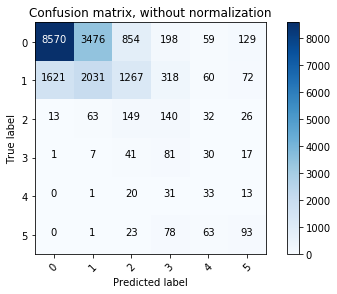

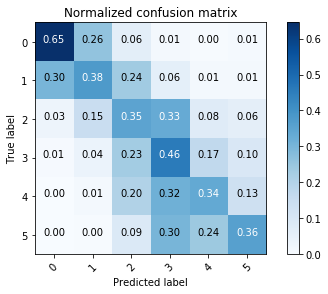

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [18]:
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Mean accuracy per class")
print(np.mean(np.diag(cm)))

Mean accuracy per class
0.421732569586


In [19]:
upper = np.diag(cm, 1)
upper = np.append(upper, 0)
diagonal = np.diag(cm)
lower = np.diag(cm, -1)
lower = np.append(0, lower)

arr = np.vstack((upper, diagonal, lower))
print("Mean accuracy in the correct class or +- 1")
print(arr.sum(axis=0).mean())

Mean accuracy in the correct class or +- 1
0.817354665681


In [20]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_classification_weights.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)